In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import galactic_wavelets as gw

In [2]:
quijote_dir = '/mnt/ceph/users/fvillaescusa/Quijote/3D_cubes/'
nb_sims = 10
test_dfs = []
for i in range(nb_sims):
    test_dfs.append(quijote_dir+f'fiducial/{i}/df_m_128_CIC_z=0.npy')
dx = 1000.0/128.0 # Mpc/h
kmax = np.pi/dx

In [3]:
dfs = []
for i in range(nb_sims):
    dfs.append(np.load(os.path.join(quijote_dir, test_dfs[i])))
dfs = np.array(dfs)
df = dfs[0]
df_shape = df.shape
N = df_shape[0]
print("Shape of the density field: ", df_shape)
print("Min/max/mean of the density field: ", df.min(), df.max(), df.mean())

Shape of the density field:  (128, 128, 128)
Min/max/mean of the density field:  -0.94043475 56.030754 -5.966285e-10


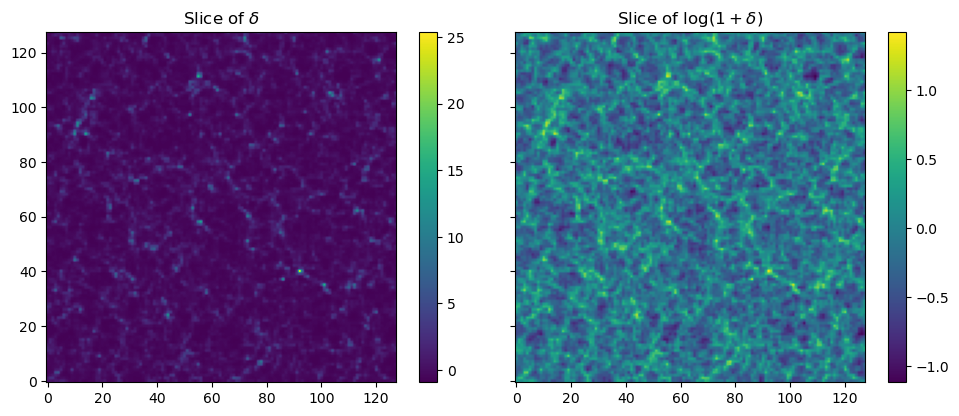

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)
im = axs[0].imshow(df[:,:,0], origin='lower')
axs[0].set_title('Slice of $\delta$')
fig.colorbar(im, ax=axs[0])
im = axs[1].imshow(np.log10(1 + df[:,:,0]), origin='lower')
axs[1].set_title('Slice of $\log(1 + \delta)$')
fig.colorbar(im, ax=axs[1])
fig.tight_layout()
plt.show()

In [5]:
J = 4
Q = 1
kc = np.pi # Cutoff frequency of the mother wavelet (in units of 2pi px^-1)
moments = (1/2, 1, 2)
erosion_threshold = 0.1

In [6]:
wst_op_full = gw.ScatteringOp(J, Q,
                              Ngrid=df_shape,
                              moments=moments,
                              kc=kc)
wst_op_half = gw.ScatteringOp(J, Q,
                              Ngrid=tuple([x//2 for x in df_shape]),
                              moments=moments,
                              kc=kc,
                              erosion_threshold=erosion_threshold)
wst_op_half.survey_mask = np.zeros(wst_op_half.Ngrid, dtype=bool) # False voxels delimit  the geometry
wst_op_half.survey_mask_vol_fraction = np.logical_not(wst_op_half.survey_mask).sum() / (wst_op_half.Ngrid[0]*wst_op_half.Ngrid[1]*wst_op_half.Ngrid[2])

wst_op_full.build_wavelets()
wst_op_half.build_wavelets()
wst_op_half.compute_wavelet_masks() # Masks are computed using erosion

Computing wavelets...
Done!
Computing wavelets...
Done!
Computing masks for the wavelet transform...
Done!


In [7]:
fwavelets = wst_op_full.fwavelets
wavelets = np.fft.fftshift(np.fft.ifftn(fwavelets, axes=(-1, -2, -3)), axes=(-1, -2, -3))
wavelets_renormalized = wavelets.copy()
for j in range(J):
    for q in range(Q):
        wavelets_renormalized[j*Q + q] *= 2**(3*(j*Q + q)/Q)
wavelets_max = np.absolute(wavelets_renormalized).max()

wavelets_supports = np.absolute(wavelets_renormalized) > erosion_threshold*wavelets_max

physical_units = True
if physical_units:
    sampling_step = np.pi/kmax
    xvals = np.arange(-N//2, N//2)*sampling_step
    kvals = 2*np.pi*np.fft.fftfreq(N, sampling_step)
else:
    sampling_step = 1.0
    xvals = np.arange(-N//2, N//2)*sampling_step
    kvals = 2*np.pi*np.fft.fftfreq(N, sampling_step)

/mnt/home/bregaldosaintblancard/miniconda3/envs/simbig/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/mnt/home/bregaldosaintblancard/miniconda3/envs/simbig/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


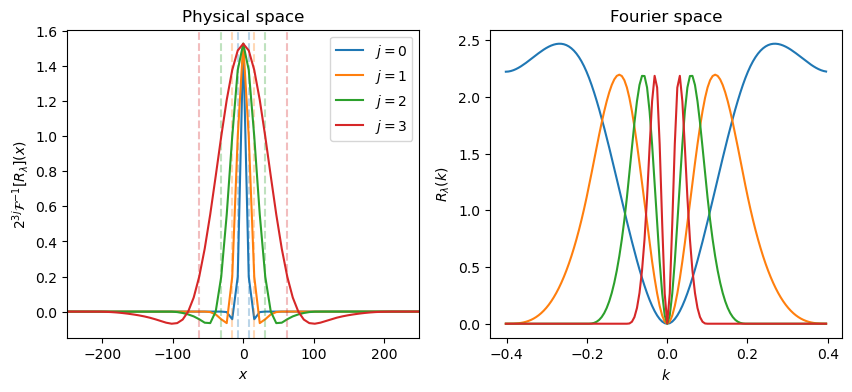

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for j in range(J):
    for q in range(Q):
        support = wavelets_supports[j*Q + q, N//2, N//2, :]
        p = axs[0].plot(xvals, wavelets_renormalized[j*Q + q, N//2, N//2, :], label=f"$j={j} + {q}/2$" if q != 0 else f"$j={j}$")
        axs[0].axvline(np.sum(support)//2*sampling_step, linestyle="dashed", alpha=0.3, color=p[0].get_color())
        axs[0].axvline(-(np.sum(support)//2*sampling_step), linestyle="dashed", alpha=0.3, color=p[0].get_color())

        axs[1].plot(np.fft.fftshift(kvals), np.fft.fftshift(fwavelets[j*Q + q, 0, 0, :]))

axs[0].legend()
axs[0].set_xlim(-N//4 * sampling_step, N//4 * sampling_step)
axs[0].set_xlabel("$x$")
axs[0].set_ylabel(r"$2^{3j}\mathcal{F}^{-1}[R_\lambda](x)$")
axs[0].set_title("Physical space")

axs[1].set_xlabel("$k$")
axs[1].set_ylabel("$R_\lambda(k)$")
axs[1].set_title("Fourier space")

fig.show()

In [9]:
s0_full, s1_full = wst_op_full(df)
s0_halfs, s1_halfs = [], []
for i in range(8):
    k, l, m = i // 4, (i % 4) // 2, i % 2
    df_half = df[k*df_shape[0]//2:(k+1)*df_shape[0]//2,
                 l*df_shape[1]//2:(l+1)*df_shape[1]//2,
                 m*df_shape[2]//2:(m+1)*df_shape[2]//2]
    s0_half, s1_half = wst_op_half(df_half)
    s0_halfs.append(s0_half)
    s1_halfs.append(s1_half)
s0_halfs, s1_halfs = np.array(s0_halfs), np.array(s1_halfs)

Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!


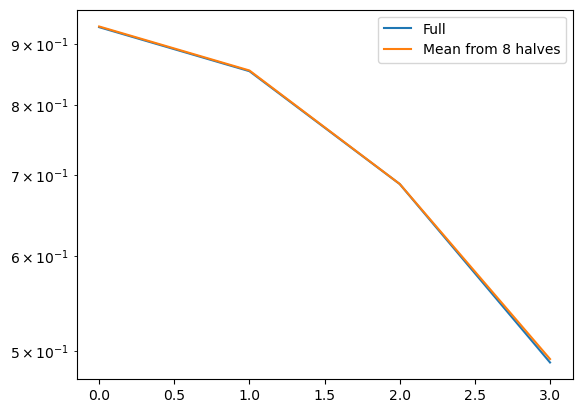

In [10]:
plt.figure()
plt.plot(s1_full[0], label='Full')
plt.plot(s1_halfs.mean(axis=0)[0], label='Mean from 8 halves')
plt.legend()
plt.yscale('log')
plt.show()

Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!


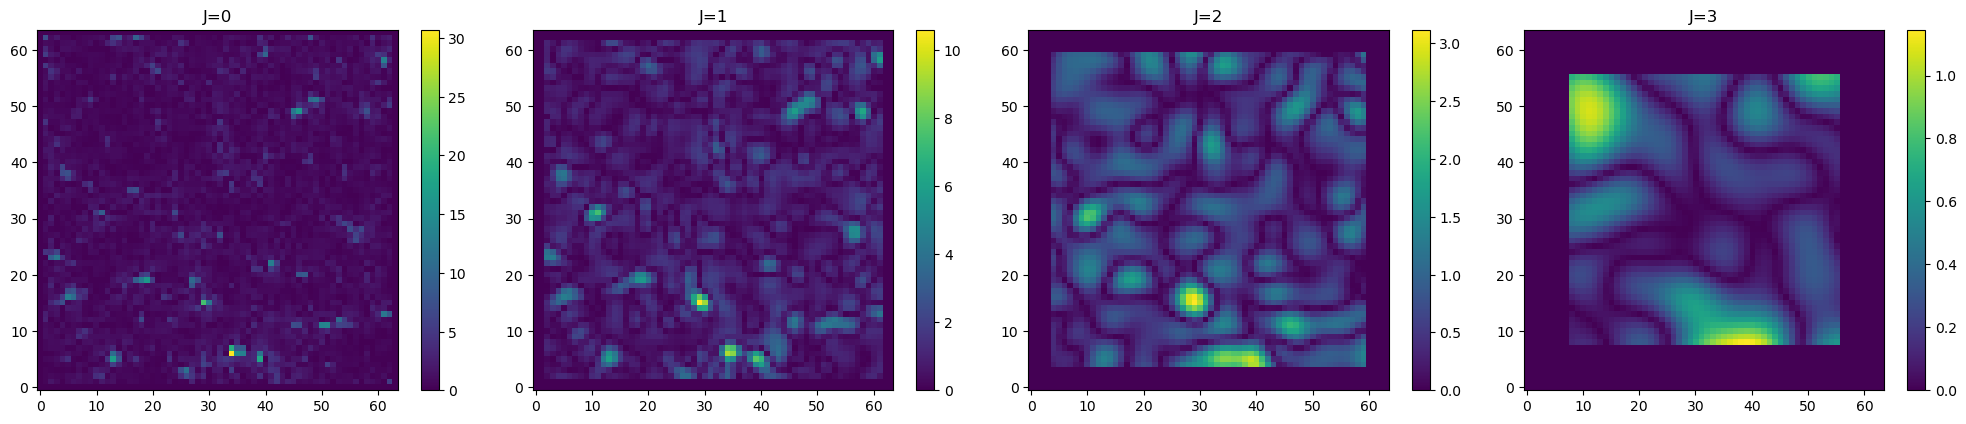

In [11]:
# Visualization of the wavelet masks
s0_half, s1_half, masked_awt = wst_op_half(df[:df_shape[0]//2, :df_shape[1]//2, :df_shape[2]//2], return_masked_abs_filtered_fields=True)
fig, axs = plt.subplots(1, J, figsize=(5*J, 4))
for j in range(J):
    im = axs[j].imshow(masked_awt[j, : ,: ,df_shape[2]//4], origin='lower')
    axs[j].set_title('J=%d' %j)
    fig.colorbar(im, ax=axs[j])
fig.tight_layout()
plt.show()

In [12]:
s0_full_list, s1_full_list = [], []
s0_halfs_list, s1_halfs_list = [], []
for j in range(nb_sims):
    s0_full, s1_full = wst_op_full(dfs[j])
    s0_full_list.append(s0_full)
    s1_full_list.append(s1_full)
    s0_halfs, s1_halfs = [], []
    for i in range(8):
        k, l, m = i // 4, (i % 4) // 2, i % 2
        df_half = dfs[j, k*df_shape[0]//2:(k+1)*df_shape[0]//2,
                    l*df_shape[1]//2:(l+1)*df_shape[1]//2,
                    m*df_shape[2]//2:(m+1)*df_shape[2]//2]
        s0_half, s1_half = wst_op_half(df_half)
        s0_halfs.append(s0_half)
        s1_halfs.append(s1_half)
    s0_halfs, s1_halfs = np.array(s0_halfs), np.array(s1_halfs)
    s0_halfs_list.append(s0_halfs)
    s1_halfs_list.append(s1_halfs)
s0_full_list, s1_full_list = np.array(s0_full_list), np.array(s1_full_list)
s0_halfs_list, s1_halfs_list = np.array(s0_halfs_list), np.array(s1_halfs_list)

Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computing S0 coefficients...
Computing S1 coefficients...
Done!
Computing statistics...
Computin

In [13]:
s0_full_list.shape, s1_full_list.shape, s0_halfs_list.shape, s1_halfs_list.shape

((10, 3), (10, 3, 4), (10, 8, 3), (10, 8, 3, 4))

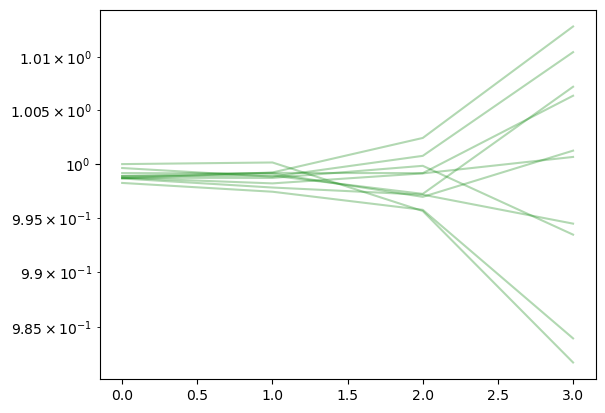

In [14]:
plt.figure()
for i in range(nb_sims):
    # plt.plot(s1_full_list[i, 0], label='Full', alpha=0.3, color='blue')
    # plt.plot(s1_halfs_list[i].mean(axis=0)[0], label='Mean from 8 halves', alpha=0.3, color='orange')
    plt.plot(s1_full_list[i, 0] / s1_halfs_list[i].mean(axis=0)[0], label='Ratio', alpha=0.3, color='green')
#plt.legend()
plt.yscale('log')
plt.show()